## Estimating metacognitive sensitivity for an EMA task with OCD

In [19]:
import pandas as pd
import numpy as np
import os
import sys
import warnings ## suppress some numpy warnings about 0 divisions


## plotting libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## import cpm libraries
import cpm.applications.signal_detection as SDT
import cpm
print(f"cpm version: {cpm.__version__}")

cpm version: 0.21.4


In [20]:
data = pd.read_csv("data/space-observer-dta.csv")

In [21]:
data.drop(columns=["Unnamed: 0"], inplace=True)
print(f"The data has {data.shape[0]} rows and {data.shape[1]} columns.")
print(f"The data contains {data['subject'].nunique()} subjects.")
data.head()

The data has 90064 rows and 12 columns.
The data contains 161 subjects.


,subject,trial,run,signal,response,accuracy,RT_choice,stimulus_intensity,modality,confidence,confidenceRT,game
0,17398,1,1,0,0,1,948,16,vision_game,NaN,NaN,1
1,17398,2,1,1,1,1,981,16,vision_game,NaN,NaN,1
2,17398,3,1,1,1,1,881,12,vision_game,NaN,NaN,1
3,17398,4,1,1,0,0,1014,12,vision_game,NaN,NaN,1
4,17398,5,1,1,1,1,866,16,vision_game,NaN,NaN,1


A single session of the experiment consists of 80 trials (excluding practice trials). Let us see how many sessions each participant completed.

Text(0, 0.5, 'Number of subjects')

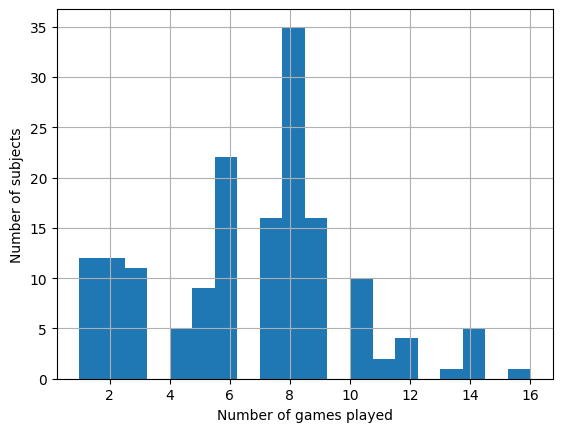

In [4]:
data.groupby("subject").game.max().hist(bins=20)
## add title and labels
plt.xlabel("Number of games played")
plt.ylabel("Number of subjects")

## Exclusions

There could be a few reasons for excluding a given participant:

1. Participant has extreme variance. Variance is to low or to high, which will not allow us to estimate metacognitive sensitivity. All discretised confidence ratings are the same, so when estimating the threshold.
2. A lot of zero values in the binned confidence ratings. Fortunately,  control for that by adjusting values by adding $1/(2 * bins)$ to each rating for all participants.
3. Participant has extreme means. Mean or median confidence is to close to 0 or to close to 100.
4. Participant has too many extreme ratings. This will cause issues when trying to discretise the confidence ratings. We are fine as long as there are either a lot of low or a lot of high ratings. But if participant has both a lot of low and high extreme ratings, we cannot control for it by simply removing individual ratings, as the number of trials will be too low. So we exclude the participant.

We start with 161 participants.

### Create the aggregate measures we will use to exclude participants

In [ ]:
inclusions = data.dropna().groupby(["subject", "game"]).agg(
    median_confidence=("confidence", "median"),
    mean_confidence=("confidence", "mean"),
    std_confidence=("confidence", "std"),
    quantile_10=("confidence", lambda x: np.percentile(x, 10)),
    quantile_25=("confidence", lambda x: np.percentile(x, 25)),
    quantile_50=("confidence", lambda x: np.percentile(x, 50)),
    quantile_75=("confidence", lambda x: np.percentile(x, 75)),
    quantile_90=("confidence", lambda x: np.percentile(x, 90)),
    n=("confidence", "count"),
    n_unique=("confidence", "nunique"),
).reset_index()
inclusions[inclusions.subject == 17422] ## an example participant who has a session that needs to be excluded based on the quantiles


count    1071.000000
mean        4.607843
std         2.888148
min         1.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        16.000000
Name: game, dtype: float64


,subject,game,median_confidence,mean_confidence,std_confidence,quantile_10,quantile_25,quantile_50,quantile_75,quantile_90,n,n_unique
88,17422,1,48.0,49.350000,19.580473,37.2,43.00,48.0,60.0,68.2,80,36
89,17422,2,58.0,53.700000,32.097320,0.0,38.00,58.0,65.5,100.0,80,33
90,17422,3,67.0,58.887500,31.469895,2.9,38.00,67.0,76.0,100.0,80,33
91,17422,4,66.5,62.825000,35.712202,0.0,33.00,66.5,100.0,100.0,80,33
92,17422,5,65.5,57.412500,30.435528,0.0,38.50,65.5,72.0,100.0,80,32
93,17422,6,71.0,70.512500,32.909155,0.0,61.75,71.0,100.0,100.0,80,24
94,17422,7,55.5,48.925000,39.610693,0.0,0.00,55.5,100.0,100.0,80,27
95,17422,8,74.5,67.377049,37.117042,0.0,40.25,74.5,100.0,100.0,122,41


In [25]:
inclusions.shape

(1071, 12)

### Remove participants with extreme variance

In [ ]:
inclusions = inclusions[(inclusions.std_confidence > 5) & (inclusions.median_confidence.between(5, 95))]
print(f"The data has {inclusions.shape[0]} rows and {inclusions.shape[1]} columns after removing outliers.")
print(f"The data contains {inclusions['subject'].nunique()} subjects after removing outliers based on extreme variances and medians.")

The data has 975 rows and 12 columns after removing outliers.
The data contains 160 subjects after removing outliers.


In [42]:
inclusions = inclusions[(inclusions.quantile_10 != inclusions.quantile_25) & (inclusions.quantile_75 != inclusions.quantile_90)]
print(f"The data has {inclusions.shape[0]} rows and {inclusions.shape[1]} columns after removing outliers.")
print(f"The data contains {inclusions['subject'].nunique()} subjects after removing outliers.")

The data has 909 rows and 12 columns after removing outliers.
The data contains 157 subjects after removing outliers.


The filtered data has 76540 rows and 12 columns.
The filtered data contains 157 subjects.


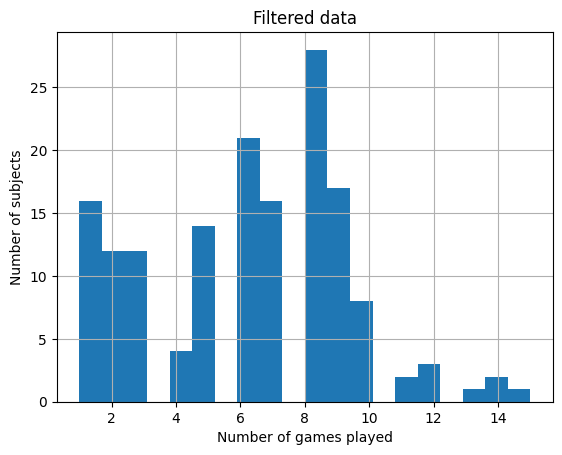

,subject,trial,run,signal,response,accuracy,RT_choice,stimulus_intensity,modality,confidence,confidenceRT,game
0,17398,1,1,0,0,1,948,16,vision_game,NaN,NaN,1
1,17398,2,1,1,1,1,981,16,vision_game,NaN,NaN,1
2,17398,3,1,1,1,1,881,12,vision_game,NaN,NaN,1
3,17398,4,1,1,0,0,1014,12,vision_game,NaN,NaN,1
4,17398,5,1,1,1,1,866,16,vision_game,NaN,NaN,1


In [49]:
filtered_data = data.merge(inclusions[['subject', 'game']], on=['subject', 'game'], how='inner')
print(f"The filtered data has {filtered_data.shape[0]} rows and {filtered_data.shape[1]} columns.")
print(f"The filtered data contains {filtered_data['subject'].nunique()} subjects.")
filtered_data.groupby("subject").game.max().hist(bins=20)
plt.xlabel("Number of games played")
plt.ylabel("Number of subjects")
plt.title("Filtered data")
plt.show()
filtered_data.head()

## Estimating metacognitive sensitivity

It seems that there are quite a bit of people who completed the experiment more than once. Actually, it seems like a pretty good turnout.

In [50]:
## suppress User and Runtime warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

## I need to add an extra column to the data frame to make it compatible with internal methods
filtered_data["observed"] = filtered_data["response"].astype(int)

optim = SDT.EstimatorMetaD(
    data=filtered_data.dropna().groupby(["subject", "game"]),
    bins=4,
    cl=None,
    parallel=True,
    libraries=["numpy", "pandas"],
    prior=True,
    display=False,
    ppt_identifier=None,
)

optim.optimise()

Starting 10 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/10 [00:00<?, ?engine/s]

In [ ]:
results = optim.export()

Text(0.5, 1.0, 'Distribution of d and meta_d')

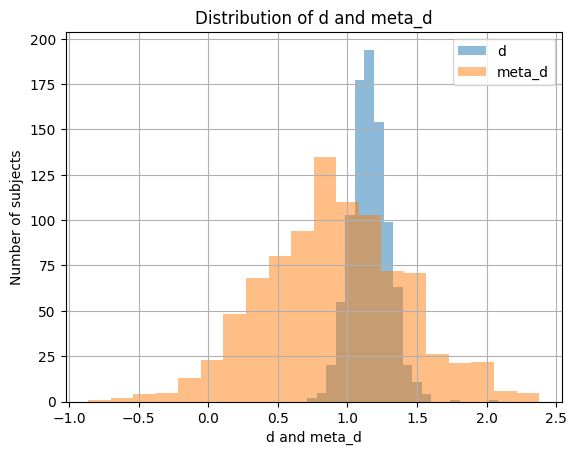

In [54]:
results.d.hist(bins=20, alpha=0.5)
results.meta_d.hist(bins=20, alpha=0.5)
plt.legend(["d", "meta_d"])
plt.xlabel("d and meta_d")
plt.ylabel("Number of subjects")
plt.title("Distribution of d and meta_d")

In [57]:
results.head()

,d,meta_d,m_diff,m_ratio,s,meta_c,t2c1_rS1_0,t2c1_rS1_1,t2c1_rS1_2,t2c1_rS2_0,...,hess_40,hess_41,hess_42,hess_43,hess_44,hess_45,hess_46,hess_47,hess_48,ppt
0,1.455690,1.583501,0.127811,1.087801,1.0,0.280397,-1.125917,-0.534495,-0.029015,0.793871,...,72.308771,-15.579360,-2.054275,0.000004,-0.000004,9.251859e-07,9.251859e-07,-15.579360,24.209822,17398
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1.445263,1.077142,-0.368121,0.745291,1.0,-0.061088,-1.365931,-0.794782,-0.416845,0.372650,...,105.861057,-28.011227,-5.234310,0.000008,0.000008,0.000000e+00,7.579123e-06,-28.011227,41.399395,17398
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
4,1.394344,0.865338,-0.529007,0.620605,1.0,-0.189890,-1.245505,-0.857241,-0.612009,0.170611,...,90.364013,-23.841657,-4.613950,0.000000,0.000008,0.000000e+00,7.579123e-06,-23.841657,36.573098,17398


Okay, that is weird, in principle, the grouping should be (ppt, game), but it creates a new row for each game. Very weird, anyways, fixed below...

In [75]:
test = results.copy()
test["game"] = test["ppt"].shift(-1)[0::2]
test = test.dropna()
test.game = test.game.astype(int)
test.dropna().head(10)


,d,meta_d,m_diff,m_ratio,s,meta_c,t2c1_rS1_0,t2c1_rS1_1,t2c1_rS1_2,t2c1_rS2_0,...,hess_41,hess_42,hess_43,hess_44,hess_45,hess_46,hess_47,hess_48,ppt,game
0,1.455690,1.583501,0.127811,1.087801,1.0,0.280397,-1.125917,-0.534495,-0.029015,0.793871,...,-15.579360,-2.054275,3.789561e-06,-3.789561e-06,9.251859e-07,9.251859e-07,-15.579360,24.209822,17398,1
2,1.445263,1.077142,-0.368121,0.745291,1.0,-0.061088,-1.365931,-0.794782,-0.416845,0.372650,...,-28.011227,-5.234310,7.579123e-06,7.579123e-06,0.000000e+00,7.579123e-06,-28.011227,41.399395,17398,2
4,1.394344,0.865338,-0.529007,0.620605,1.0,-0.189890,-1.245505,-0.857241,-0.612009,0.170611,...,-23.841657,-4.613950,0.000000e+00,7.579123e-06,0.000000e+00,7.579123e-06,-23.841657,36.573098,17398,3
6,1.153305,1.255985,0.102680,1.089031,1.0,-0.056904,-1.375279,-0.818469,-0.443257,0.348868,...,-27.708671,-3.833315,-7.579123e-06,-1.515825e-05,-7.579123e-06,0.000000e+00,-27.708671,39.990140,17398,4
8,1.497531,0.419492,-1.078039,0.280122,1.0,-0.009039,-1.197354,-0.721804,-0.171127,0.521801,...,-50.281622,-5.148776,-1.850372e-06,-1.850372e-06,0.000000e+00,-1.850372e-06,-50.281622,64.652282,17398,5
10,1.348048,1.190083,-0.157966,0.882819,1.0,-0.214787,-1.842167,-0.951815,-0.627223,0.180472,...,-59.192289,-7.207211,-9.251859e-07,-9.251859e-07,2.864375e-06,3.789561e-06,-59.192289,74.882510,17398,6
12,1.595961,1.344617,-0.251344,0.842512,1.0,-0.168688,-1.312867,-0.881370,-0.399844,0.402497,...,-20.425227,-6.081451,3.789561e-06,3.789561e-06,2.864375e-06,2.864375e-06,-20.425227,32.558421,17399,1
14,1.066859,1.286731,0.219872,1.206093,1.0,-0.025923,-1.544782,-1.000635,-0.501754,0.251647,...,-29.929965,-3.965717,1.850372e-06,0.000000e+00,0.000000e+00,0.000000e+00,-29.929965,44.693472,17399,2
16,1.133179,1.416485,0.283306,1.250010,1.0,0.226588,-1.295940,-0.760440,-0.258561,0.550858,...,-24.927310,-2.824434,-7.579123e-06,0.000000e+00,0.000000e+00,-9.429494e-06,-24.927310,36.681507,17399,3
18,1.122804,1.561553,0.438749,1.390761,1.0,-0.181738,-1.503866,-1.151341,-0.725947,0.122070,...,-21.768300,-8.423371,-7.579123e-06,-7.579123e-06,-4.714747e-06,-3.789561e-06,-21.768300,37.423833,17399,4


In [76]:
test.to_csv("space-observer-metad.csv", index=False)